In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
os.chdir('../')

In [3]:
from utils_analysis import logs_to_plot

from delfi.distribution import Uniform
from delfi.generator import Default
from delfi.inference import SNPE  # , Basic, CDELFI

from dap.utils import (obs_params, syn_obs_stats, syn_obs_data,
                       load_current, load_prior_ranges)
from dap.dap_sumstats_step_mom import DAPSummaryStatsStepMoments
from dap.dap_simulator import DAPSimulator
from dap import DAPcython

In [4]:
name = '_test__notebook_save'
directory = 'results/dap_model' + name

n_rounds = 3
n_samples = 1000
prior_mixin = 80
epochs = 1000

n_hiddens = [6]
n_params = 2

n_summary = 17
n_components = 1
reg_lambda = 0.01

In [5]:
# picking experiments observables
observables = {'loss.lprobs', 'imputation_values', 'h1.mW', 'h1.mb', 'h2.mW',
               'h2.mb', 'weights.mW', 'weights.mb', 'means.mW0', 'means.mW1',
               'means.mb0', 'means.mb1', 'precisions.mW0', 'precisions.mW1',
               'precisions.mb0', 'precisions.mb1'}

In [6]:
# Load the current
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'    # best cell
protocol = 'IV' # 'IV' # 'rampIV' # 'Zap20'
ramp_amp = 1
I, v, t, t_on, t_off, dt = load_current(data_dir, protocol=protocol, ramp_amp=ramp_amp)
I_ramp, v_ramp, t_ramp, t_on_ramp, t_off_ramp, dt_ramp = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)

In [7]:
# Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U_ramp = dap.simulate(dt_ramp, t_ramp, I_ramp)
U = dap.simulate(dt, t, I)

In [8]:
# generate data format for SNPE / OBSERVABLE
x_o = {'data': v.reshape(-1),
       'time': t,
       'dt': dt,
       'I': I}

In [9]:
# Setup Priors
prior_min, prior_max, labels = load_prior_ranges(n_params)
prior_unif = Uniform(lower=prior_min, upper=prior_max)

samples_prior = prior_unif.gen(n_samples=int(5e5))
idx = np.arange(0, len(x_o['data']))

In [10]:
# Summary Statistics
S = syn_obs_stats(x_o['I'], params=params, dt=x_o['dt'], t_on=t_on, t_off=t_off,
                  n_summary=n_summary, summary_stats=1, data=x_o)

M = DAPSimulator(x_o['I'], x_o['dt'], -75)

s = DAPSummaryStatsStepMoments(t_on, t_off, n_summary=n_summary)
G = Default(model=M, prior=prior_unif, summary=s)  # Generator

In [11]:
# Runing the simulation
inf_snpe = SNPE(generator=G, n_components=n_components, n_hiddens=n_hiddens, obs=S,
                reg_lambda=reg_lambda, prior_mixin=prior_mixin, pilot_samples=0)

inf_snpe.standardize_init()

obs (1, 12)
mean (1, 12)
std (12,)


In [12]:
#run
logs, tds, posteriors = inf_snpe.run(n_train=[n_samples], n_rounds=n_rounds,
                                     proposal=prior_unif, monitor=observables,
                                     epochs=epochs, round_cl=1)

Training (round 3) : 100%|██████████| 1000000/1000000 [00:13<00:00, 76634.71it/s]


In [13]:
for i, posterior in enumerate(posteriors):
    print('mean of {} round:'.format(i+1), posterior.mean)

for i, posterior in enumerate(posteriors):
    print('std of {} round:'.format(i+1), posterior.std)

mean of 1 round: [11.01919483  0.9114005 ]
mean of 2 round: [11.82609294  6.30756467]
mean of 3 round: [17.90462217  2.95546454]
std of 1 round: [2.43819974 0.64922389]
std of 2 round: [1.51443847 0.        ]
std of 3 round: [8.01551075 3.11725163]


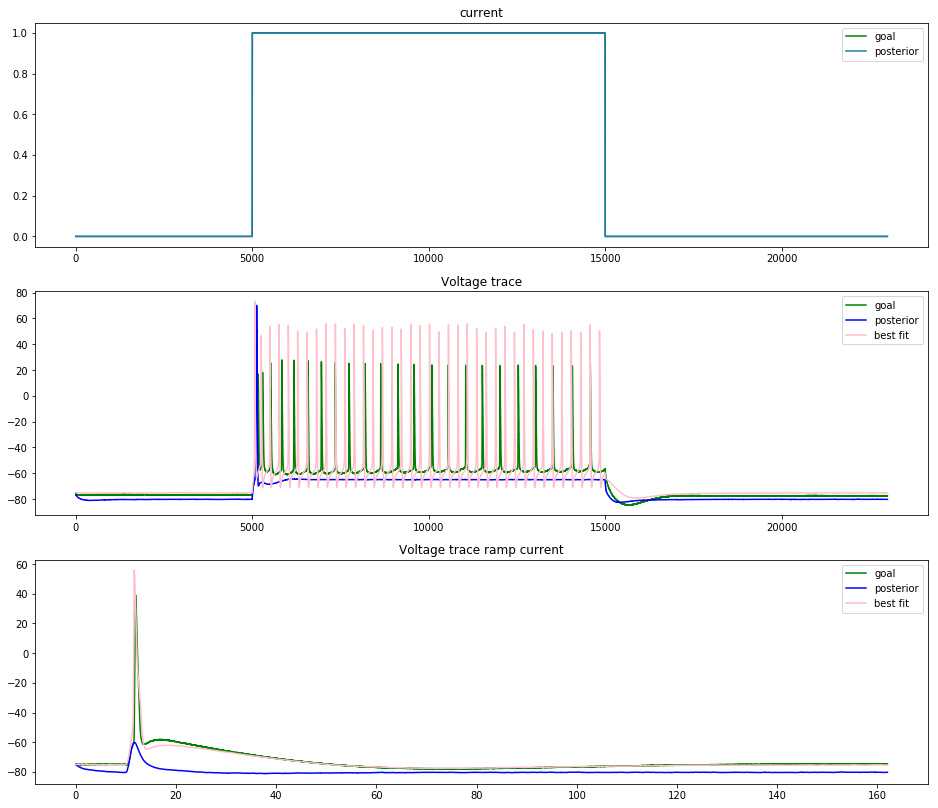

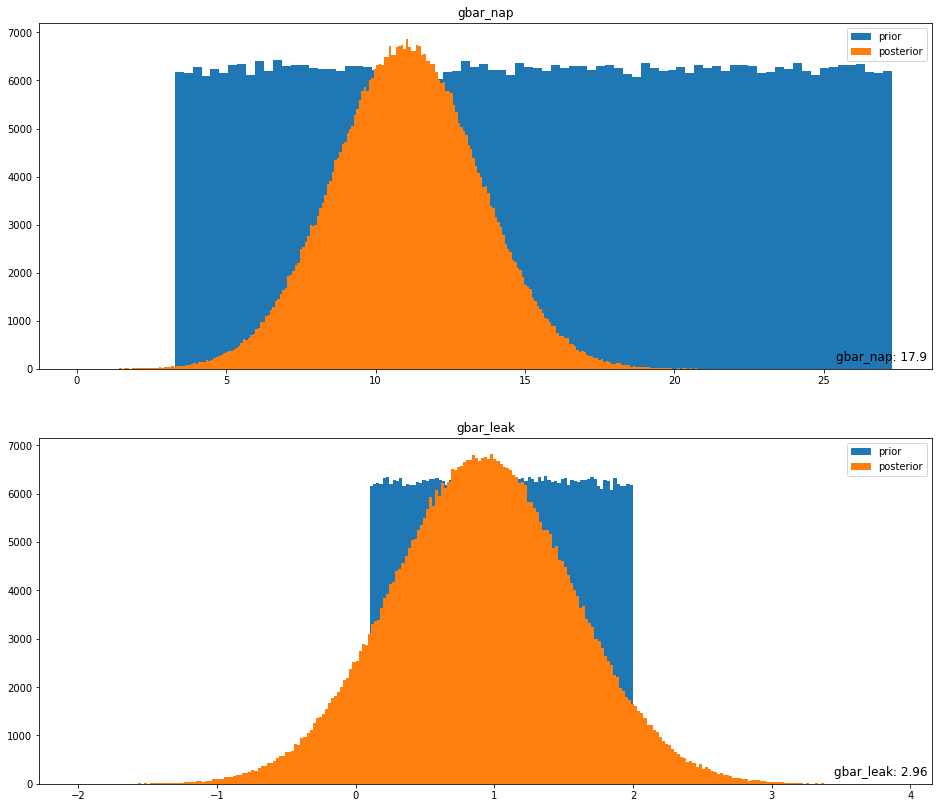

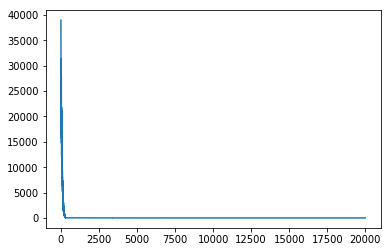

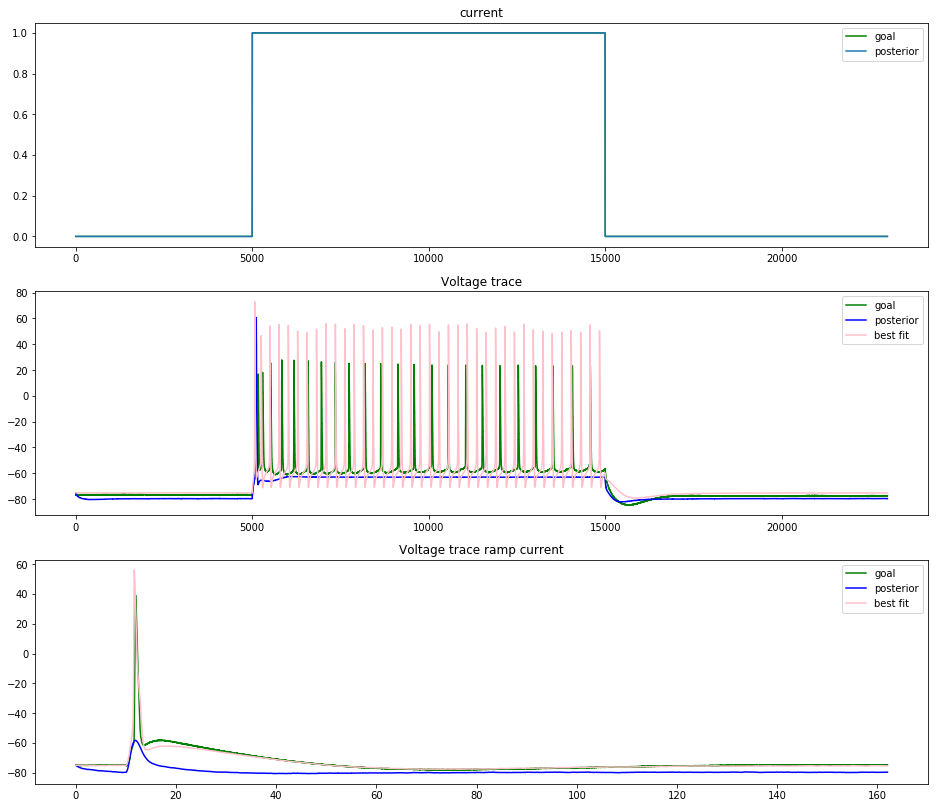

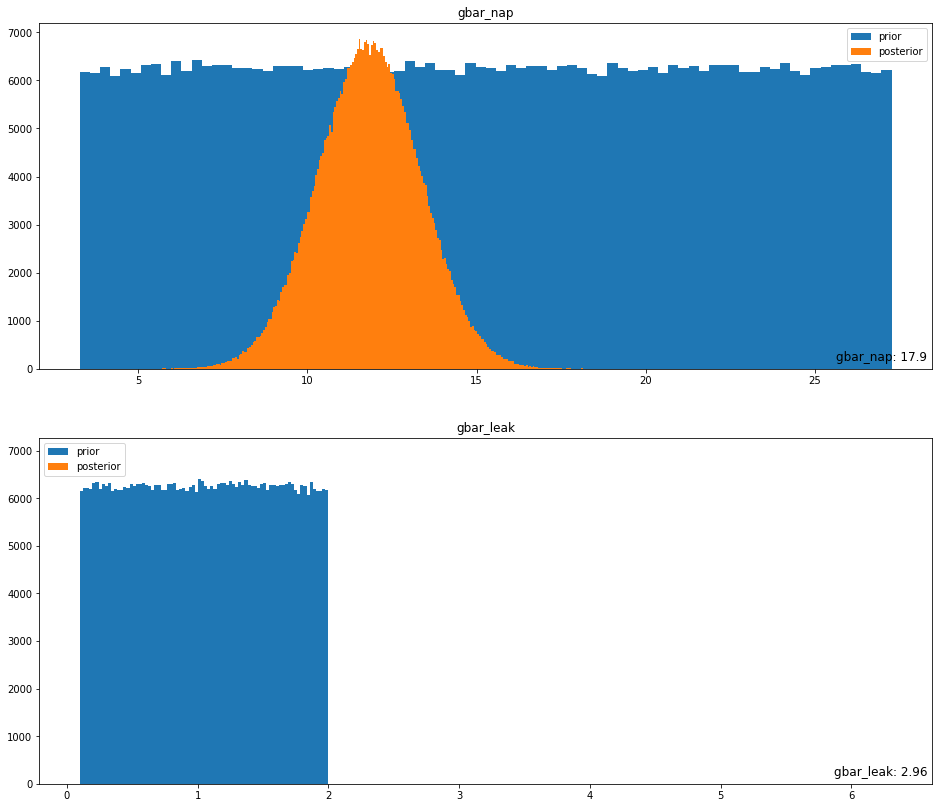

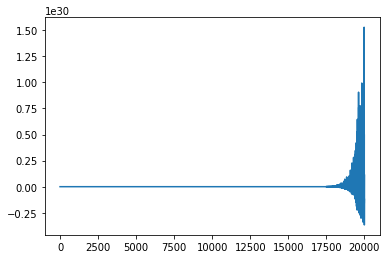

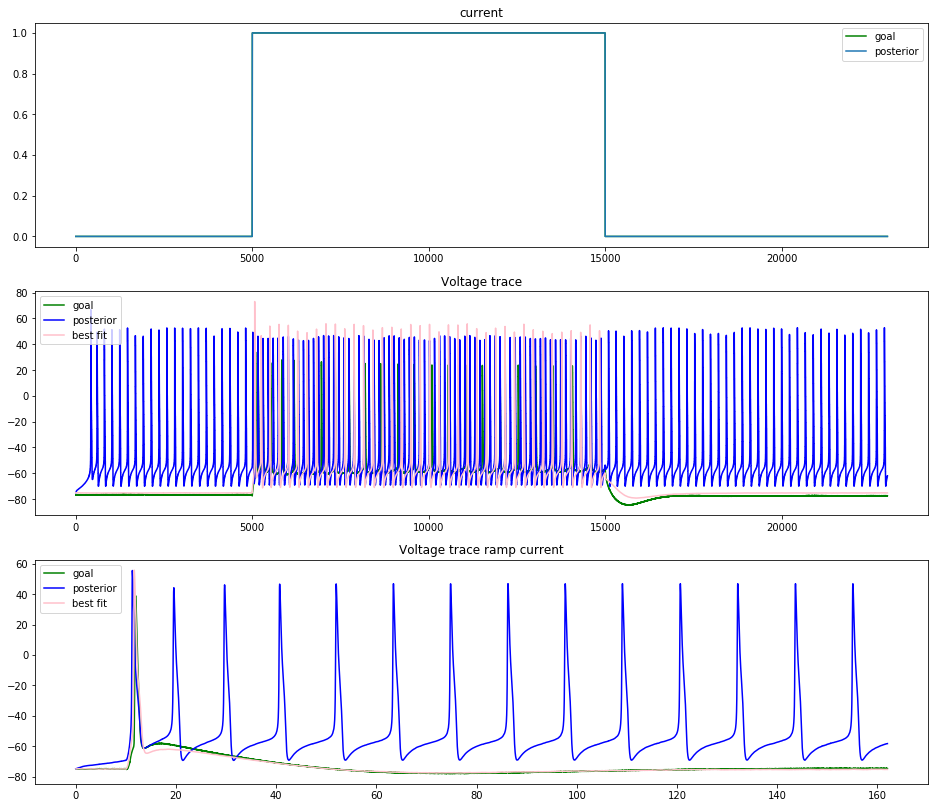

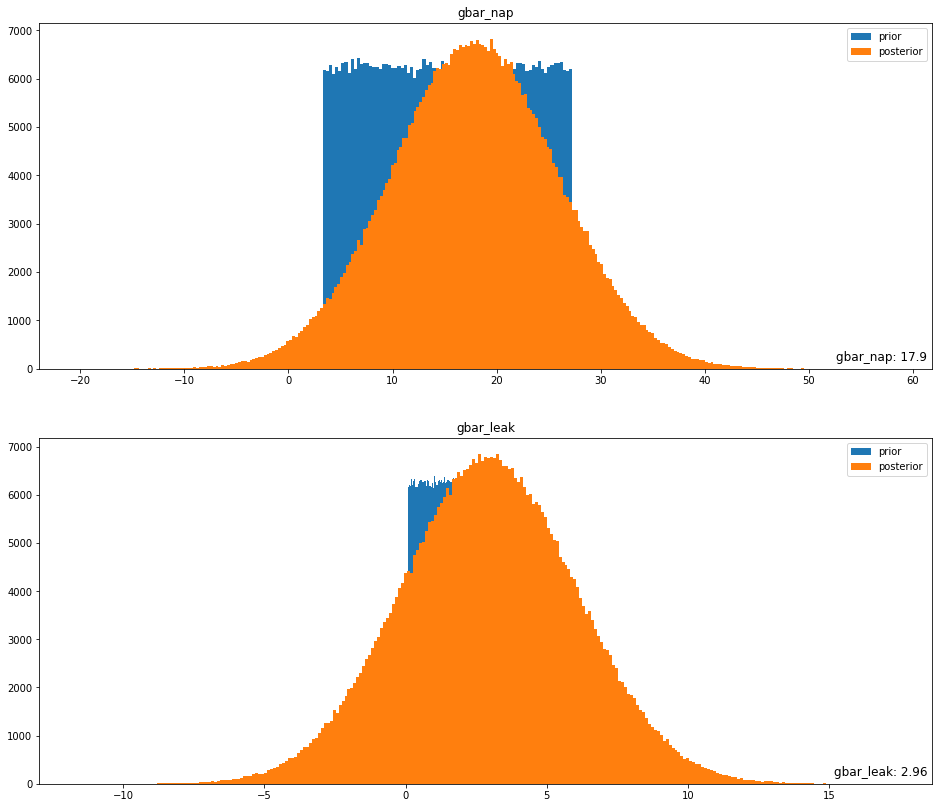

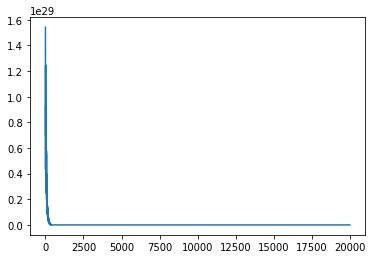

In [14]:
for i, posterior in enumerate(posteriors):
#     dir_out = directory + '/1x' + str(i+1)

#     if not os.path.exists(dir_out):
#         print('creating directory')
#         os.makedirs(dir_out)

    # Analyse results
    samples_posterior = posterior.gen(n_samples=int(5e5))


    x_post = syn_obs_data(I, dt, posterior.mean)
    x_post_ramp = syn_obs_data(I_ramp, dt_ramp, posterior.mean)

    idx = np.arange(0, len(x_o['data']))

    # Create Plots
    simulation, axes = plt.subplots(3, 1, figsize=(16,14))
    axes[0].plot(idx, x_o['I'], c='g', label='goal')
    axes[0].plot(idx, x_post['I'], label='posterior')
    axes[0].set_title('current')
    axes[0].legend()

    axes[1].step(idx, x_o['data'], c='g', label='goal')
    axes[1].step(idx, x_post['data'], c='b', label='posterior')
    axes[1].plot(idx, U, c='pink', label='best fit')
    axes[1].set_title('Voltage trace')
    axes[1].legend()

    axes[2].plot(t_ramp, v_ramp, c='g', label='goal')
    axes[2].plot(t_ramp, x_post_ramp['data'], c='b', label='posterior')
    axes[2].plot(t_ramp, U_ramp, c='pink', label='best fit')
    axes[2].set_title('Voltage trace ramp current')
    axes[2].legend()


    distr_comb, axes = plt.subplots(nrows=n_params, figsize=(16,14))
    for ii, l in enumerate(labels):

        axes[ii].hist(samples_prior[:, ii], bins='auto', label='prior')
        axes[ii].hist(samples_posterior[:, ii], bins='auto', label='posterior')

        axes[ii].set_title(l)
        axes[ii].annotate(l+': '+str(round(posteriors[-1].mean[ii], 2)),
                        xy=(1, 0), xycoords='axes fraction', fontsize=12,
                        xytext=(-5, 5), textcoords='offset points',
                        ha='right', va='bottom')

        axes[ii].legend()



    loss, ax = plt.subplots(1,1)
    ax.plot(logs[i]['loss'])

Generating wegiths Plots


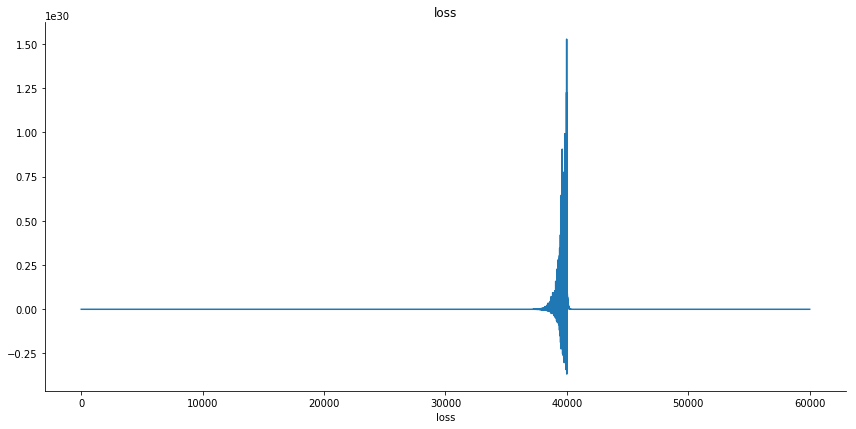

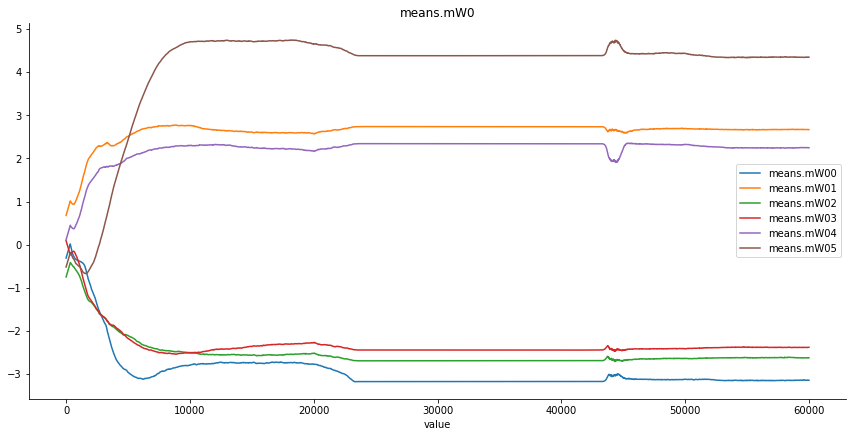

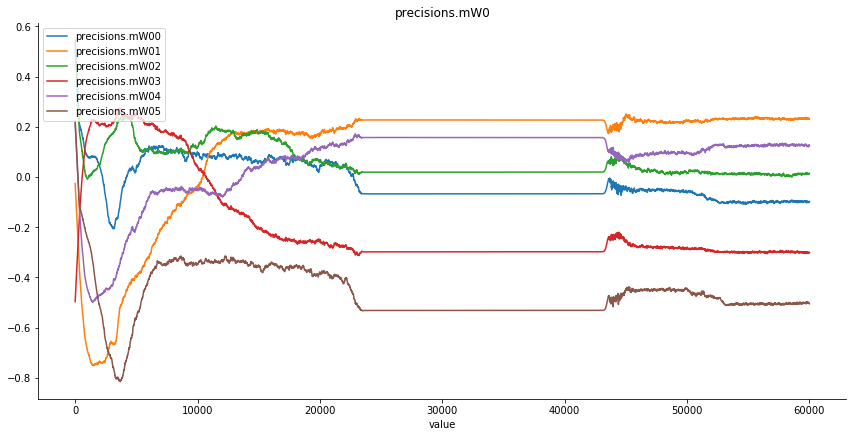

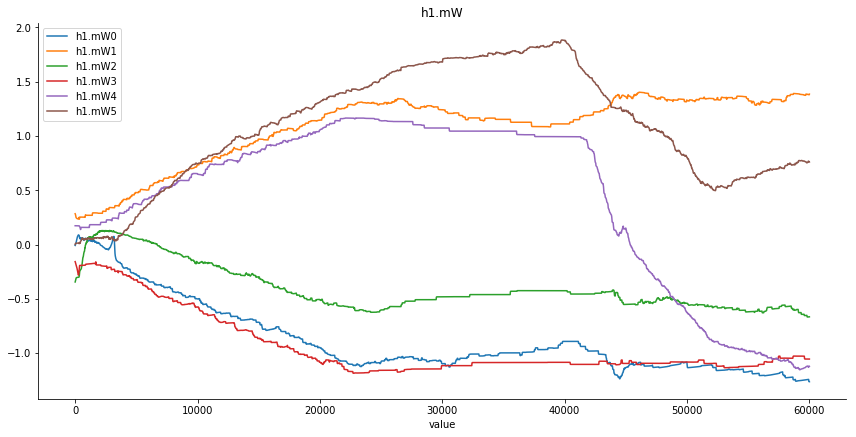

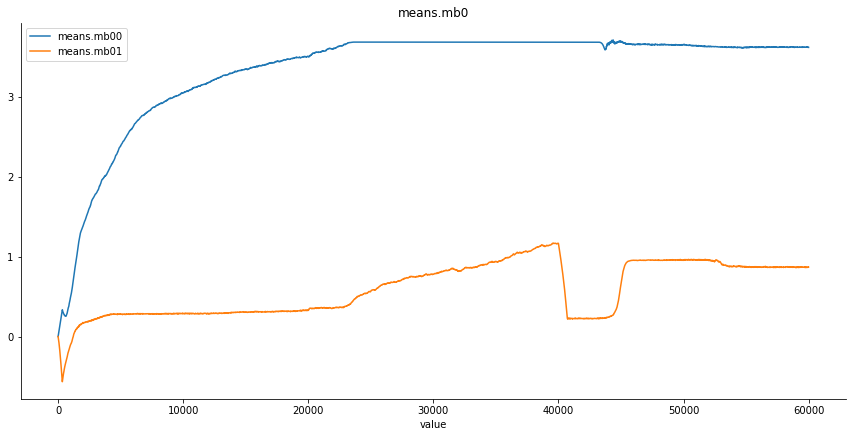

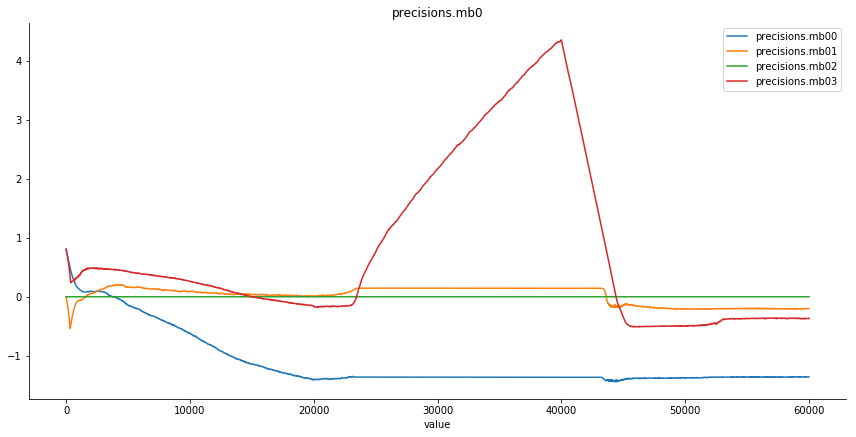

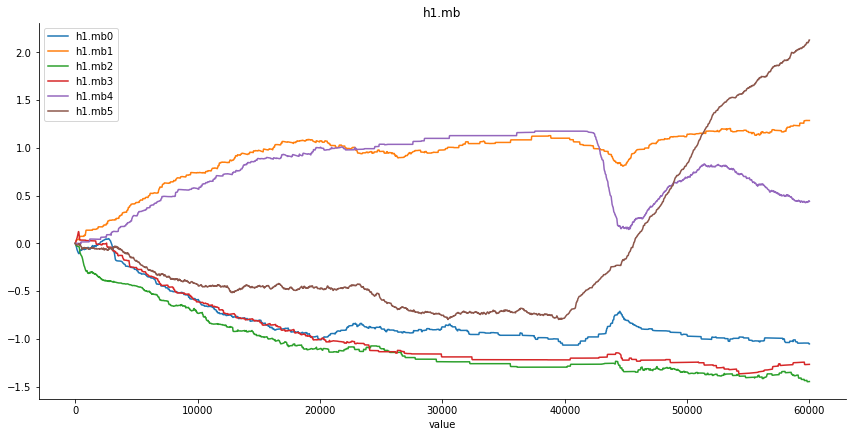

In [15]:
# Create Weights Plots
print('Generating wegiths Plots')

g_loss = logs_to_plot(logs, 'loss')
g_meansW0 = logs_to_plot(logs, 'means.mW0', melted=True)
g_precisionsW0 = logs_to_plot(logs, 'precisions.mW0', melted=True)
g_h1W = logs_to_plot(logs, 'h1.mW', melted=True)

# Create Biases Plots
g_meansb0 = logs_to_plot(logs, 'means.mb0', melted=True)
g_precisionsb0 = logs_to_plot(logs, 'precisions.mb0', melted=True)
g_h1b = logs_to_plot(logs, 'h1.mb', melted=True)

In [16]:
#     # Saving plots
#     print('Saving Plots')

#     loss.savefig(dir_out + '/loss.png', bbox_inches='tight')
#     distr_comb.savefig(dir_out + '/distr_comb.png', bbox_inches='tight')
#     simulation.savefig(dir_out + '/simulation.png', bbox_inches='tight')

#     g_loss.savefig(dir_out + '/g_loss.png', bbox_inches='tight')
#     g_meansW0.savefig(dir_out + '/meansW0.png', bbox_inches='tight')
#     g_precisionsW0.savefig(dir_out + '/precisionsW0.png', bbox_inches='tight')
#     g_h1W.savefig(dir_out + '/h1W.png', bbox_inches='tight')

#     g_meansb0.savefig(dir_out + '/meansb0.png', bbox_inches='tight')
#     g_precisionsb0.savefig(dir_out + '/precisionsb0.png', bbox_inches='tight')
#     g_h1b.savefig(dir_out + '/h1b.png', bbox_inches='tight')


#     # Close all the figures
#     loss.clf()
#     distr_comb.clf()
#     simulation.clf()

### Save Parameters

In [17]:
parameters = pd.DataFrame(data=posteriors[-1].mean, index=labels,
                          columns=['mean param'])
parameters
# parameters.to_csv(path_or_buf=dir_out + '/parameters.csv')

,mean param
gbar_nap,17.904622
gbar_leak,2.955465


In [18]:
posteriors_means = []
for i, posterior in enumerate(posteriors):
    posteriors_means.append(posterior.mean)
    
posteriors_means = pd.DataFrame(data=posteriors_means, columns=labels)    
posteriors_means
# posteriors_means.to_csv(path_or_buf=dir_out + '/parameters_mean.csv')

,gbar_nap,gbar_leak
0,11.019195,0.911400
1,11.826093,6.307565
2,17.904622,2.955465


In [19]:
posteriors_std = []
for i, posterior in enumerate(posteriors):
    posteriors_std.append(posterior.std)
    
posteriors_std = pd.DataFrame(data=posteriors_std, columns=labels)    
posteriors_std
# posteriors_std.to_csv(path_or_buf=dir_out + '/parameters_std.csv')

,gbar_nap,gbar_leak
0,2.438200,0.649224
1,1.514438,0.000000
2,8.015511,3.117252


In [20]:
# Save hyperparameters
hyper = {
    'name': name,
    'n_rounds': n_rounds,
    'n_summary': n_summary,
    'n_samples': n_samples,
    'n_hidden': str(n_hiddens),
    'n_components': n_components,
    'protocol': protocol,
    'ramp_amp': ramp_amp,
    'prior_min': str([0, 1]),
    'prior_max': str([0.5, 30]),
}

hyperparams = pd.DataFrame(hyper, index=[0])
hyperparams
# hyperparams.to_csv(path_or_buf=directory + '/hyperparam.csv')

,name,n_rounds,n_summary,n_samples,n_hidden,n_components,protocol,ramp_amp,prior_min,prior_max
0,_test__notebook_save,3,17,1000,[6],1,IV,1,"[0, 1]","[0.5, 30]"
